# 1월 28일

In [3]:
import cv2, numpy as np
import math
import time
import random
from matplotlib import pyplot as plt
%matplotlib inline


def imshow(tit, image) :
    plt.title(tit)    
    if len(image.shape) == 3 :
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else :
        plt.imshow(image, cmap="gray")
    plt.show()

In [5]:
orb = cv2.ORB_create()
matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING)

images = ['book/book1.jpg', 'book/book2.jpg', 'book/book3.jpg', 'book/book4.jpg', ] 

database_kp = []
database_desc = []
for name in images :
    img = cv2.imread(name, cv2.IMREAD_GRAYSCALE) #gray로 읽음
    keypoints, desc = orb.detectAndCompute(img, None) #코너점(keypoints)->특징점
    database_kp.append(keypoints) #데이터베이스 보관
    database_desc.append(desc)

18.64
52.74
59.92
38.08


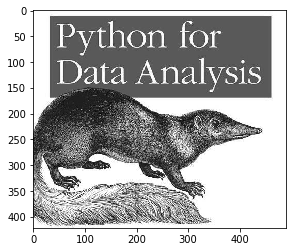

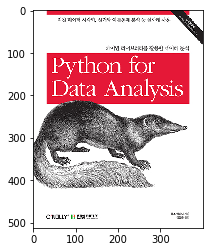

In [9]:
test = cv2.imread("book/book1test.jpg", cv2.IMREAD_GRAYSCALE)
keypoints, desc = orb.detectAndCompute(test, None)

min_distance = 1000
idx = -1
for i in range(len(images)) :   
    matches = matcher.match(desc, database_desc[i]) #match: 두점에 대한 mapping관계
    matches = sorted(matches, key=lambda x: x.distance) 
    good_matches = matches[:50] #최상위 50개만 match하겠다.
    
    distance = 0
    for d  in good_matches : #거리를 잰다.
        distance += d.distance
    distance /= len(good_matches)  #50개에 대한 평균거리
    print(distance) #18.64 =가장 가까운 거리
    
    if  min_distance > distance : #평균 거리가 가장 작은 것
        min_distance = distance
        idx = i

imshow("", test)
imshow("", cv2.imread(images[idx]))

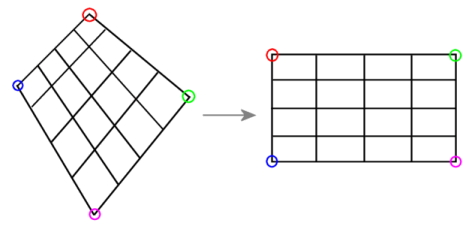

In [48]:
from IPython.display import Image
Image("homography.png")

In [39]:
#이미지 매칭
src1=cv2.imread('book/box.png',cv2.IMREAD_GRAYSCALE) # queryImage
src2=cv2.imread('book/box_in_scene.png',cv2.IMREAD_GRAYSCALE) # trainImage

keypoints1, desc1 = orb.detectAndCompute(src1, None)
keypoints2, desc2 = orb.detectAndCompute(src2, None)

matches = matcher.match(desc1, desc2) 
matches = sorted(matches, key=lambda x: x.distance) 
good_matches = matches[:50]

In [40]:
dst=cv2.drawMatches(src1, keypoints1, src2, keypoints2, good_matches, None,
                    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

pts1=np.array([keypoints1[m.queryIdx].pt #매칭된 점들에 대해서 좌표 출력/쿼리인덱스
               for m in good_matches]).reshape(-1,1,2).astype(np.float32)
pts2=np.array([keypoints2[m.trainIdx].pt
               for m in good_matches]).reshape(-1,1,2).astype(np.float32)
print(pts1.shape) #(50,1,2)

H,_=cv2.findHomography(pts1,pts2,cv2.RANSAC) #RANdom SAmple Consensus
print(H) #3x3행렬(회전정보, 이동정보)

(50, 1, 2)
[[ 4.85610150e-01 -1.26423343e-01  1.16639863e+02]
 [ 3.62734153e-02  4.76039278e-01  1.58710108e+02]
 [-1.20390936e-04 -1.08741047e-04  1.00000000e+00]]


[[[  0.   0.]]

 [[  0. 222.]]

 [[323. 222.]]

 [[323.   0.]]]
[[[116.63986 158.71011]]

 [[ 90.76499 270.93124]]

 [[261.93488 294.67987]]

 [[284.5573  177.32181]]]


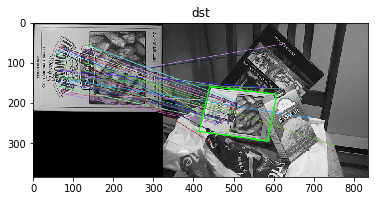

In [41]:
(h,w)=src1.shape[:2]
corners1=np.array([[0,0],[0,h-1],[w-1,h-1],[w-1,0]]).reshape(-1,1,2).astype(np.float32)
corners2=cv2.perspectiveTransform(corners1,H)
print(corners1)
print(corners2) #4x1x2 행렬

corners3=corners2+np.float32([w,0]) #broadcasting #debugging을 위해서 [w,0] 더해줌
cv2.polylines(dst,[np.int32(corners3)],True,(0,255,0),2,cv2.LINE_AA)
imshow('dst',dst)

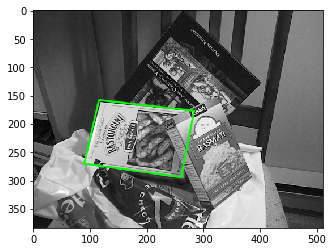

In [42]:
test=cv2.imread('book/box_in_scene.png')
cv2.polylines(test,[np.int32(corners2)],True,(0,255,0),2,cv2.LINE_AA)
imshow('',test)

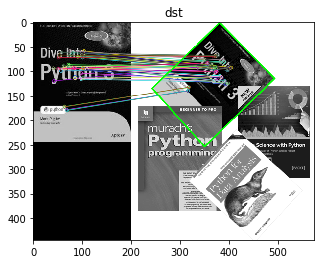

In [47]:
#이미지 매칭 실습
src1=cv2.imread('book/book2.jpg',cv2.IMREAD_GRAYSCALE)
src2=cv2.imread('book/exam.png',cv2.IMREAD_GRAYSCALE)

keypoints1, desc1 = orb.detectAndCompute(src1, None)
keypoints2, desc2 = orb.detectAndCompute(src2, None)

matches = matcher.match(desc1, desc2) 
matches = sorted(matches, key=lambda x: x.distance) 
good_matches = matches[:50]

dst=cv2.drawMatches(src1, keypoints1, src2, keypoints2, good_matches, None, 
                    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

pts1=np.array([keypoints1[m.queryIdx].pt
               for m in good_matches]).reshape(-1,1,2).astype(np.float32)
pts2=np.array([keypoints2[m.trainIdx].pt
               for m in good_matches]).reshape(-1,1,2).astype(np.float32)

H,_=cv2.findHomography(pts1,pts2,cv2.RANSAC) 

(h,w)=src1.shape[:2]
corners1=np.array([[0,0],[0,h-1],[w-1,h-1],[w-1,0]]).reshape(-1,1,2).astype(np.float32)
corners2=cv2.perspectiveTransform(corners1,H)

corners3=corners2+np.float32([w,0])
cv2.polylines(dst,[np.int32(corners3)],True,(0,255,0),2,cv2.LINE_AA)
imshow('dst',dst)

*getPerspectiveTransform vs findHomography

#cv2.getPerspectiveTransform( ): 4개의 점만을 이용해서 변환 행렬을 찾는다. 확실하게 대응되는 점 세트 4개를 알고 있는 경우, cv2.getPespectiveTransfrom( )함수를 사용해서 투영 변환 행렬을 구해주면 된다.

#cv2.findHomography( ): 4개 이상의 대응점들을 통해 변환 행렬을 찾아주고, 이 과정에서 정확한 변환 행렬을 찾는데 방해가 되는 outlier를 제거하기 위해 RANSAC 알고리즘을 사용하도록 설정해줄 수 있다.
#4개 이상의 대응되는 점들을 알고 있는데, 이 점들의 대응 신뢰도가 떨어져서 모든 점이 정확하게 매칭된 점이라 확신할 수 없고, 가장 좋은 4개만을 뽑아서 cv2.getPerspectiveTransform( )을 사용하기엔 가장 좋은 4개를 선택할 기준이 없어 애매한 경우

In [ ]:
#Fashion-MNIST with tf.Keras
#https://tykimos.github.io/2018/09/30/Hello_Fashion_MNIST/
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()